# Univariate n-lagged Random Forest  

From:  https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

Random Forest models leverage the value of many trained decision trees - making it an ensemble technique - to come up with an estimator that delivers the best balance between goodness of fit (low bias) and generalization (low variance).  In regression modelling this means averaging the output of the estimates, while in classification this means a "win by votes".  

Timeseries data can be processed to be modelled using supervised learning algotithms like Random Forest.  The data must be "lagged", that is, the model is prompted to predict a target at time t using information from time t-1 (or t-n if n lags are imposed).  And this can be done for an autoregression, where a target is predicted based only on past values of itself, or it can be done for a multivariate scenario where a target variable is predicted on past values of itself and past values for the feature variables that impact on the target.

Here is an overview of the steps carried out in this effort:
* The raw dataset must be lagged to the desired lag value, and the lagged versions of the variables must be collated for input  
> For this univariate model, it was found in the EDA that a lag of one would likely do best.  However the code below does allow for setting a different lag value.
* The variables are split into training and test datasets
* The RandomForest is configured and fit on training data
* Predicted values are generated as "one-step" walking forecast predictions on a model re-fit with the training dataset and the last-used test data point/row.  
* These one-step walking forecast predictions are compared to their actual observations for plotting and the calculation of mean absolute error (MAE).  This mirrors a set-up where models are updated real-time on observed data as it is available. (! I'd like to streamline which errors are used on the various model trials, or have a good reason to deviate in one framework or other)

### Stationarity   

In the eda notebooks, the data was found to be stationary by the Augmented Dickey-Fuller test.

It is generally agreed that the data need not be stationary for LSTM models, however, it is recommended to get an idea of the stationarity of your data anyway as it may inform decisions around the useful life of your model and when a refresh may be required.

https://datascience.stackexchange.com/questions/30362/checking-for-stationarity-in-lstm#:~:text=You%20may%20want%20to%20force,you%20a%20boost%20in%20performance.  

To check for stationarity in Python, consult the following:  
https://machinelearningmastery.com/time-series-data-stationary-python/  

Tests for stationarity, generally:  

"There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. The ADF test is a widely used test for checking the stationarity of a time series, and it checks for the presence of a unit root in the data."  (Analytics Vidhya)  

The below code is taken from:    

The intention is to later adapt the templated code for multivariate forecasting.

[[4. 5.]
 [5. 4.]
 [4. 3.]
 ...
 [3. 1.]
 [1. 3.]
 [3. 5.]]
>expected=2.0, predicted=9.3
>expected=6.0, predicted=4.2
>expected=8.0, predicted=6.4
>expected=5.0, predicted=9.7
>expected=1.0, predicted=6.3
>expected=2.0, predicted=3.8
>expected=3.0, predicted=4.3
>expected=4.0, predicted=4.8
>expected=3.0, predicted=6.1
>expected=1.0, predicted=4.8
>expected=3.0, predicted=3.6
>expected=5.0, predicted=4.7
MAE: 2.697


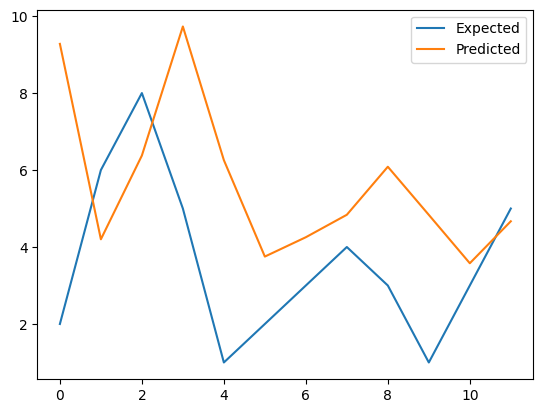

In [2]:
# forecast weekly dengue cases
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
sj_df_cases = sj_df['total_cases']
sj_df_cases_list = sj_df_cases.values.astype('float32').tolist()
# transform the time series data into supervised learning
data = series_to_supervised(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up
# a red flag is if you're doing a univariate timeseries with lag 1 and you're getting more than 2 columns when this prints
print(data)				
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

____________________________________________________________________
## Understanding the processing above  

The below repeats what's above, but with a lot of commenting to better understand it, and with some bits and pieces of code trialled under it to really see the outputs from and the inputs to various parts.  It's a sort of "flowchart-in-progress".

In [3]:
# forecast weekly dengue cases
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1] # if multivariate, it'll be 'else' and it's the column index for your variables. Not used here.  
	df = DataFrame(data)								# you feed this function an array either as a list (y(t) only for AR/UV), or multi-column (y(t) & features)
	cols = list()										# so it has no column names anymore (if it did before) and it's turned into a dataframe with numbers for column names
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):						# starts at the highest lag value you specified and will loop down to lag 1 (t-1)
		cols.append(df.shift(i))						# shifts/lags entire dataframe of variables (inputs & output variable)
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):							# generally using just y(t), so n_out=1 most often
		cols.append(df.shift(-i))						# produces y(t)
	# put it all together
	agg = concat(cols, axis=1)							# put all the columns together in the same order they were appended in
	# drop rows with NaN values; shifting produces NaNs
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values									# produces a numpy ndarray (can't get first 5 rows), no column headers (n)

# split a univariate dataset into train/test sets: retain last "n_test" rows for the test set
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):						# could add a parameter f, for fraction, and replace n_test with int(f*len(data))
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array: remember, history is an array of arrays, or list of arrays, each entry of which is [y(t-1), y(t)]
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)						# it's trying to fit parameters to get yhat to be as close as possible to y(t)/trainy using y(t-1)/trainX
	# make a one-step prediction
	yhat = model.predict([testX])					# now predict y(t) using testX (last 12/n_test rows of lagged y), and it's only the ith row of the test, so one set of lagged inputs in a time snapshot
	return yhat[0]									# why just yhat[0]... it only produces the one prediction on one row of test data, but maybe this was written for cases where there's more
													# than just y(t) for outputs.  Someone may wish to model for y(t+k).

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)	# train is first rows up to the last n_test rows, test is the last n_test rows; all columns (inputs & output)
	# seed history with training dataset			# train is many rows long by variables (ins & out) wide
	history = [x for x in train]					## basically the output of series_to_supervised (data) but each row made into array [y(t-1), y(t)] - it's an array of arrays
	# step over each time-step in the test set
	for i in range(len(test)):						
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]	# per series_to_supervised, first columns are lagged y, the last column is y(t); not sure how this works if n_out>1; grabbing only the ith row
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX) # history is the training set of inputs (lagged y) and output (y(t)), testX *here* is ONLY the ith row of the testX set (the last 12 rows (n_test) of lagged y)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])						  # it's the one row at test[i], but all columns (y(t-1) and y(t)), appended (so it's added as a list I think) to the training rows already put in earlier
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions) # I may yet try root mean squared error to match LSTM metric.  Not yet clear why I'd pick one over the other (to do with outlier penalty)
	return error, test[:, -1], predictions

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
data_x = sj_df['total_cases']
list_x = data_x.values.astype('float32').tolist()
# transform the time series data into supervised learning
data = series_to_supervised(list_x, n_in=1) # one time lag for my univariate set-up
print(data)
# evaluate
# mae, y, yhat = walk_forward_validation(data, 12)
# print('MAE: %.3f' % mae)
# # plot expected vs predicted
# pyplot.plot(y, label='Expected')
# pyplot.plot(yhat, label='Predicted')
# pyplot.legend()
# pyplot.show()

[[4. 5.]
 [5. 4.]
 [4. 3.]
 ...
 [3. 1.]
 [1. 3.]
 [3. 5.]]


Testing various bits of code below.  

First, let's examine what we're feeding series_to_supervised.

In [4]:
test_series = read_csv('sj_df.csv', header=0, index_col=0)
#test_series # the whole dataframe, obv, as that's what sj_df is
test_values = test_series.values
test_values

array([[ 4.00000000e+00,  1.22600000e-01,  1.03725000e-01, ...,
         1.24200000e+01,  1.40128571e+01,  2.62857143e+00],
       [ 5.00000000e+00,  1.69900000e-01,  1.42175000e-01, ...,
         2.28200000e+01,  1.53728571e+01,  2.37142857e+00],
       [ 4.00000000e+00,  3.22500000e-02,  1.72966700e-01, ...,
         3.45400000e+01,  1.68485714e+01,  2.30000000e+00],
       ...,
       [ 1.00000000e+00, -1.55200000e-01, -5.27500000e-02, ...,
         1.69600000e+01,  1.41842857e+01,  2.18571429e+00],
       [ 3.00000000e+00,  1.80000000e-03, -5.27500000e-02, ...,
         0.00000000e+00,  1.38585714e+01,  2.78571429e+00],
       [ 5.00000000e+00, -3.70000000e-02, -1.03666700e-02, ...,
         0.00000000e+00,  1.56714286e+01,  3.95714286e+00]])

Now execute the first thing that series_to_supervised does, see the results.

In [5]:
test_series = read_csv('sj_df.csv', header=0, index_col=0)
#test_series # the whole dataframe, obv, as that's what sj_df is
test_values = test_series.values        # effectively strips away the column names, it's no longer set up like a dataframe as we're used to seeing
#test_values
# series_to_supervised takes your list or multi-column array and makes into a dataframe of columns with column indices for names
test_df = DataFrame(test_values)
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4.0,0.122600,0.103725,0.198483,0.177617,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571
1,5.0,0.169900,0.142175,0.162357,0.155486,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429
2,4.0,0.032250,0.172967,0.157200,0.170843,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000
3,3.0,0.128633,0.245067,0.227557,0.235886,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571
4,6.0,0.196200,0.262200,0.251200,0.247340,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,4.0,0.077850,-0.039900,0.310471,0.296243,296.958571,296.957143,292.095714,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714
932,3.0,-0.038000,-0.016833,0.119371,0.066386,298.081429,298.228571,293.235714,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286
933,1.0,-0.155200,-0.052750,0.137757,0.141214,297.460000,297.564286,292.732857,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714
934,3.0,0.001800,-0.052750,0.203900,0.209843,297.630000,297.778571,292.274286,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714


Now let's understand just what the heck the history variable looks like, so we can make sense of the walk forward validation.

In [6]:
# first all this happens:
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
data_x = sj_df['total_cases']
list_x = data_x.values.astype('float32').tolist()
# transform the time series data into supervised learning
data = series_to_supervised(list_x, n_in=1) # one time lag for my univariate set-up
#print(data) # 2 columns (y(t-1), y(t)) as expected

# next, data gets fed to walk_forward_validation along with the test set size (n_test), which is 12 in this case:
train, test = train_test_split(data, 12) # takes the first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
# many sanity checks follow.  sleep deprivation means more sanity checks.
#train # outputs as expected: one array of rows, each containing y(t-1) and y(t)
#len(data)
#len(train)
#len(test)
# test_len_check
#len(data) - len(train) == len(test) # happy.
#test # 12 rows, as expected
history = [x for x in train]
history # basically the output of series_to_supervised (data) but each row made into array [y(t-1), y(t)] - it's an array of arrays, I guess
        # for some reason this gets put back later... see the comments below around the 'asarray' line.

[array([4., 5.]),
 array([5., 4.]),
 array([4., 3.]),
 array([3., 6.]),
 array([6., 2.]),
 array([2., 4.]),
 array([4., 5.]),
 array([ 5., 10.]),
 array([10.,  6.]),
 array([6., 8.]),
 array([8., 2.]),
 array([2., 6.]),
 array([ 6., 17.]),
 array([17., 23.]),
 array([23., 13.]),
 array([13., 21.]),
 array([21., 28.]),
 array([28., 24.]),
 array([24., 20.]),
 array([20., 40.]),
 array([40., 27.]),
 array([27., 42.]),
 array([42., 33.]),
 array([33., 43.]),
 array([43., 37.]),
 array([37., 57.]),
 array([57., 71.]),
 array([71., 44.]),
 array([44., 56.]),
 array([56., 53.]),
 array([53., 52.]),
 array([52., 47.]),
 array([47., 26.]),
 array([26., 27.]),
 array([27., 21.]),
 array([21., 21.]),
 array([21., 26.]),
 array([26., 34.]),
 array([34., 37.]),
 array([37., 17.]),
 array([17., 19.]),
 array([19., 25.]),
 array([25., 18.]),
 array([18., 21.]),
 array([21., 17.]),
 array([17., 17.]),
 array([17., 16.]),
 array([16., 16.]),
 array([16., 15.]),
 array([15., 23.]),
 array([23., 16.]),


Ok, now let's understand what `.predict()` outputs from the random forest regressor

In [7]:
# first all this happens:
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
data_x = sj_df['total_cases']
list_x = data_x.values.astype('float32').tolist()
# transform the time series data into supervised learning
data = series_to_supervised(list_x, n_in=1) # one time lag for my univariate set-up
#print(data) # 2 columns (y(t-1), y(t)) as expected
# next, data gets fed to walk_forward_validation along with the test set size (n_test), which is 12 in this case:
train, test = train_test_split(data, 12) # takes the first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
history = [x for x in train]
history # basically the output of series_to_supervised (data) but each row made into array [y(t-1), y(t)] - it's an array of arrays, I guess
# next what happens..
# for i in range(len(test)), so let's set it to zero.  REMEMBER: for each iteration of this loop, it sends the ONE row of testX (per the range counter) and calls the random forest forecast function
testX, testy = test[0, :-1], test[0, -1]        # here it's grabbing row i (zero for this case) and assigning the input columns (lagged y) to testX and the output column (y(t)) to testy
# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
history = asarray(history)
#history                 # back to the array we had before with train before it was fed to [x for x in train]?? 2 columns of training data, y(t-1), y(t)
trainX, trainy = history[:, :-1], history[:, -1] # again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates by lagged y and y
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)						# it's trying to fit parameters to get yhat to be as close as possible to y(t)/trainy using y(t-1)/trainX
# make a one-step prediction
yhat = model.predict([testX])					# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat											# riddle me this... if we're sending the random forest forecast fxn ONE testX row at a time, how's it going to predict more than 1 value for yhat?  So I repeat...
#return yhat[0]									# why yhat[0]?  Or... does it have to do with possibly setting n_out to something greater than 1 in series_to_supervised? (I'd have to go back over the impact)


array([9.23400663])

What if I use the `.predict()` to feed the entire testX (not just one row at a time)?  It'll produce 12 predictions based on the 12 sets of lagged inputs (only y(t-1) in this case).

So why can't I feed all 12 test rows to `.predict()` on a fitted model?

Well, if you keep your model fixed, and this is a matter of what practice is used in which setting (occasional model refresh vs real-time refitting), then you can just feed it inputs from a test set or live new values and get the predictions.  In a real-time refitting scenario, the known target values can be added to the timeseries fed to the model and the model can be refit to supply the next prediction.

I'd have to go back and see what the LSTM model does.  Calculating model performances using different practices seems problematic.

Careful not to feed it [test_X], you want to feed it only (test_X) if you're sending it all of testX at a time.

In [8]:
# first all this happens:
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
data_x = sj_df['total_cases']
list_x = data_x.values.astype('float32').tolist()
# transform the time series data into supervised learning
data = series_to_supervised(list_x, n_in=1) # one time lag for my univariate set-up
#print(data) # 2 columns (y(t-1), y(t)) as expected
# next, data gets fed to walk_forward_validation along with the test set size (n_test), which is 12 in this case:
train, test = train_test_split(data, 12) # takes the first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
history = [x for x in train]
history # basically the output of series_to_supervised (data) but each row made into array [y(t-1), y(t)] - it's an array of arrays, I guess
# next what happens..
# for i in range(len(test)), so let's set it to zero.  REMEMBER: for each iteration of this loop, it sends the ONE row of testX (per the range counter) and calls the random forest forecast function
testX, testy = test[:, :-1], test[:, -1]        # here it's grabbing row i (zero for this case) and assigning the input columns (lagged y) to testX and the output column (y(t)) to testy
# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
history = asarray(history)
#history                 # back to the array we had before with train before it was fed to [x for x in train]?? 2 columns of training data, y(t-1), y(t)
trainX, trainy = history[:, :-1], history[:, -1] # again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)						# it's trying to fit parameters to get yhat to be as close as possible to y(t)/trainy using y(t-1)/trainX
# make a one-step prediction

#testX = asarray(testX).reshape(1, -1)
yhat = model.predict(testX)					# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat											# riddle me this... if we're sending the random forest forecast fxn ONE testX row at a time, how's it going to predict more than 1 value for yhat?  So I repeat...
#return yhat[0]									# why yhat[0]?  Or... does it have to do with possibly setting n_out to something greater than 1 in series_to_supervised? (I'd have to go back over the impact)
                                                # I would think setting n_out = 2 would have series_to_supervised produce two outputs: y(t) and y(t+1), in which case EACH gets a prediction... I need to mull this.


array([9.252376  , 4.16238064, 6.36555098, 9.64908102, 6.2278961 ,
       3.72877729, 4.16238064, 4.84856964, 6.10751358, 4.84856964,
       3.72877729, 4.84856964])

Just to understand what's being sent to `.predict()` (structure)

In [9]:
testX

array([[9.],
       [2.],
       [6.],
       [8.],
       [5.],
       [1.],
       [2.],
       [3.],
       [4.],
       [3.],
       [1.],
       [3.]])